In [1]:
import numpy as np
import qiskit as qis

from numpy.random import default_rng

from qiskit.exceptions import QiskitError
from qiskit.quantum_info.operators.random import * 
from qiskit_aer.backends import AerSimulator
from qiskit.quantum_info import *
from qiskit.primitives import Sampler

import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.result import marginal_counts
from qiskit.quantum_info import random_statevector

from qiskit.quantum_info import Pauli
from qiskit_aer.noise import NoiseModel, pauli_error
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error, amplitude_damping_error)
#from qiskit.extensions import Initialize

from matplotlib.pyplot import figure



%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\Botond\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# Mapping

This file contains all the needed processes for the mapping of hard logical connectives to quantum circuits. 

The logical connectives are stored in nested lists, which we iterate through to allocate qubits and ancillas for the connectives.

Qubit Mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'anc1': 4, 'anc2': 5, 'anc3': 6, 'anc4': 7}


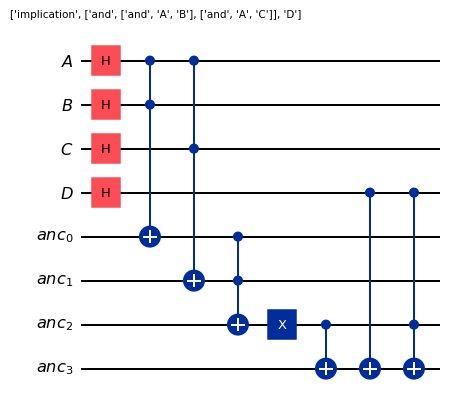

In [2]:


def extract_variables(expr):
    """Recursively extract unique variables from the logical expression.
    Checks if expr is a list and if it is it skips the first element (the logical connective)
    and adds the variables to the set (which is good because automatically handles the duplicates)"""
    variables = set()
    if isinstance(expr, list):
        for sub_expr in expr[1:]:  # Skip the connective (e.g., "and", "or")
            variables.update(extract_variables(sub_expr))
    elif isinstance(expr, str):  # It's a variable (e.g., "A", "B")
        variables.add(expr)
    return variables

def count_connectives(expr):
    """Recursively count the number of logical connectives.
    Checks if expr is a list and if it is it adds +1 to count"""
    count = 0
    if isinstance(expr, list):
        count += 1  # Count this connective
        for sub_expr in expr[1:]:
            count += count_connectives(sub_expr)
    return count

def resolve_expression(expr, circuit, qubits_map, ancilla_start, ancilla_counter):
    """Recursively resolve nested logical expressions and translate them to Q gates.
    Returns the qubit index storing the result of this sub-expression."""
    if isinstance(expr, str):  # It's a variable
        return qubits_map[expr]
    
    if isinstance(expr, list) and len(expr) > 1:
        """If the expr is a list it selects the first argument as the gate (logical connective) and the others as the qubits"""
        gate = expr[0]  # The logical connective (e.g., "and", "or", etc.)
        args = expr[1:]

        # Resolve arguments recursively
        """By rerunning it we get the arguments as they form a sting when checking with the isinstance and collects them"""
        resolved_args = [resolve_expression(arg, circuit, qubits_map, ancilla_start, ancilla_counter) for arg in args]

        # Allocate ancilla for this operation
        """For every quantum gate set we have an ancilla where we store the final output
        the position of this ancilla must shift/change so we do not get piled up"""
        target = ancilla_start + ancilla_counter[0]
        ancilla_counter[0] += 1  # Increment the counter

        # Apply Quantum Gates for Logical Connectives
        """Then it applies the quantum gate representing the logical connective"""
        if gate == "not" and len(resolved_args) == 1:
            circuit.x(resolved_args[0])  
            circuit.cx(resolved_args[0], target)  

        elif gate == "and" and len(resolved_args) == 2:
            q1, q2 = resolved_args
            circuit.ccx(q1, q2, target)  

        elif gate == "or" and len(resolved_args) == 2:
            q1, q2 = resolved_args
            circuit.cx(q1, target)  
            circuit.cx(q2, target)  
            circuit.ccx(q1, q2, target)  

        elif gate == "xor" and len(resolved_args) == 2:
            q1, q2 = resolved_args
            circuit.cx(q1, target)  
            circuit.cx(q2, target)  

        elif gate == "implication" and len(resolved_args) == 2:
            q1, q2 = resolved_args
            circuit.x(q1)    
            circuit.cx(q1, target)  
            circuit.cx(q2, target)  
            circuit.ccx(q1, q2, target)  

        elif gate == "bijection" and len(resolved_args) == 2:
            q1, q2 = resolved_args
            circuit.cx(q1, target)  
            circuit.cx(q2, target)  
            circuit.x(target)  

        else:
            raise ValueError(f"Unknown or improperly formatted gate: {gate}")
        
        return target

def logical_to_quantum(expression):
    """Automatically maps logical expressions to quantum circuits with dynamic qubit allocation."""
    # Extract variables and count connectives
    variables = extract_variables(expression)
    num_ancilla = count_connectives(expression)

    # Dynamic Qubit Mapping
    var_list = sorted(list(variables))  #sort the variables
    qubits_map = {var: idx for idx, var in enumerate(var_list)} #get the qubits from the no. of variables
    ancilla_start = len(qubits_map) #have the ancillas properly sorted
    ancilla_map = {f"anc{i+1}": ancilla_start + i for i in range(num_ancilla)}    #get the qubits from the no. of ancillas
    qubits_map.update(ancilla_map)  #update the no. of qubits

    # Create Quantum Register with Named Qubits

    circuit = QuantumCircuit()
    for name in sorted(variables):
        qreg = QuantumRegister(1, name=name)
        circuit.add_register(qreg)
        
    anc_reg = QuantumRegister(num_ancilla, name = "anc")
    """out_reg = ClassicalRegister(1, name = "OUT")
    circuit.add_register(anc_reg, out_reg)"""
    circuit.add_register(anc_reg)
        
    #qreg = QuantumRegister(len(qubits_map), name="q")
    #creg = ClassicalRegister(1, name="OUT")
    #circuit = QuantumCircuit(qreg, creg) #generate the quantum registers and circuit based on the no. of variables + ancillas
    
    
    #Add Hadamard Gates to Basis Qubits to create superposition
    basis_qubits = set(range(len(variables)))  # Indices of the logical variables
    for q in basis_qubits:
        circuit.h(q)  # Apply Hadamard to each basis qubit

    # Resolve the expression
    ancilla_counter = [0]  # Use a list to keep the counter mutable
    final_result = resolve_expression(expression, circuit, qubits_map, ancilla_start, ancilla_counter)
    #print(f"Final result stored in qubit: {final_result}")  #show where do we store the final qubit
    
    return circuit, qubits_map


# Example Logical Expression
ex1 = ["or", ["or", "A", "B"], ["not", "C"]]
ex2 = ["implication", ["xor", ["and", "A", "B"], ["and", "C", "D"]], ["and", "E", "F"]]
ex3 = ["implication",   ["and", ["and", "A", "B"], ["and", "A", "C"]], "D"]

# Generate Quantum Circuit with Dynamic Qubit Allocation
qc, qubits_map = logical_to_quantum(ex3)
print("Qubit Mapping:", qubits_map)

fig = figure()
ax = fig.add_subplot()

ax.set_title(ex3, fontsize=7.5, loc = 'left')

qc.draw('mpl', ax = ax)  # Draw the circuit


In [3]:
import random

LOGICAL_CONNECTIVES = ["and", "or", "not", "xor", "implication", "bijection"]

def generate_random_expression(variables, depth):
    seed = 7
    """
    Generates a random nested logical expression ensuring distinct arguments.

    Args:
        variables (list): List of variable names (e.g., ["A", "B", "C"]).
        depth (int): Maximum depth of nesting in the expression.

    Returns:
        list or str: A nested logical expression.
    """
    if depth == 0 or (random.random() < 0.3 and depth > 1):  
        return random.choice(variables)  # Return a random variable

    connective = random.choice(LOGICAL_CONNECTIVES)  

    if connective == "not":  
        return ["not", generate_random_expression(variables, depth - 1)]  # Unary case
    
    # Generate two unique operands
    operand1 = generate_random_expression(variables, depth - 1)
    
    # Ensure operand2 is different from operand1
    while True:
        operand2 = generate_random_expression(variables, depth - 1)
        if operand2 != operand1:
            break  # Only accept distinct operands

    return [connective, operand1, operand2]

# Example usage:
variables = ["A", "B", "C", "D", "E", "F", "G", "H"]
random_expression = generate_random_expression(variables, depth=5)

print(random_expression)

['implication', ['implication', ['or', 'B', ['xor', ['and', 'C', 'E'], ['not', 'A']]], 'A'], ['implication', ['or', ['implication', ['not', 'G'], ['bijection', 'H', 'E']], ['or', ['xor', 'F', 'B'], ['and', 'F', 'B']]], ['and', ['xor', ['implication', 'H', 'A'], ['implication', 'B', 'E']], 'A']]]


In [4]:
import random

LOGICAL_CONNECTIVES = ["and", "or", "not", "xor", "implication", "bijection"]

def generate_expression_with_limits(variables, total_qubits, max_depth=3, seed=None):
    """
    Generate a logical expression with limited depth and total qubit budget.
    
    Args:
        variables (list): List of variable names (e.g., ["A", "B", "C"]).
        total_qubits (int): Max number of qubits = variables + connectives (ancillas).
        max_depth (int): Maximum depth of the expression tree.
        seed (int or None): Seed for reproducibility.

    Returns:
        expression: Nested logical expression.
    """
    if seed is not None:
        random.seed(seed)

    connectives_used = [0]
    max_connectives = total_qubits 
    used_vars = set()

    def helper(depth):
        # Base case: max depth reached or no more ancilla budget
        if depth == 0 or connectives_used[0] >= max_connectives or (random.random() < 0.3 and len(used_vars) < len(variables)):
            var = random.choice(variables)
            used_vars.add(var)
            return var

        op = random.choice(LOGICAL_CONNECTIVES)

        if op == "not":
            if connectives_used[0] >= max_connectives:
                return random.choice(variables)
            connectives_used[0] += 1
            return ["not", helper(depth - 1)]

        # Binary ops
        if connectives_used[0] >= max_connectives:
            return random.choice(variables)
        
        connectives_used[0] += 1
        left = helper(depth - 1)
        right = helper(depth - 1)

        while right == left:
            right = helper(depth - 1)

        return [op, left, right]

    expression = helper(max_depth)
    return expression

variables = ["A", "B", "C", "D", "E", "F", "G", "H"]
total_qubits = 30  # vars + ancillas
max_depth = 7
seed = 987655467

random_expression = generate_expression_with_limits(variables, total_qubits, max_depth, seed)
print(random_expression)

['xor', ['bijection', ['bijection', ['and', 'H', 'A'], 'F'], ['not', 'H']], ['or', ['or', 'G', ['not', ['implication', 'A', ['and', ['implication', 'B', 'A'], ['or', 'B', 'H']]]]], ['or', ['and', 'E', ['and', ['and', ['bijection', 'D', 'C'], ['not', 'G']], ['bijection', ['not', 'A'], ['implication', 'B', 'G']]]], ['xor', ['or', ['and', ['xor', 'D', 'F'], ['or', 'B', 'F']], ['xor', ['implication', 'B', 'A'], ['and', 'E', 'H']]], ['and', 'C', 'A']]]]]


In [5]:
random_expression =  ['and', ['bijection', ['and', ['and', ['and', 'A', 'D'], ['implication', 'C', 'H']], ['or', ['and', 'C', 'A'], ['or', 'G', 'D']]], ['and', ['bijection', ['or', 'G', 'H'], ['implication', 'G', 'D']], ['not', ['and', 'C', 'F']]]], ['and', ['or', ['bijection', ['not', 'E'], ['implication', 'E', 'C']], ['not', ['implication', 'A', 'G']]], 'B']]

    - 25 : ['implication', ['or', ['implication', 'A', 'G'], ['bijection', ['or', ['xor', 'D', 'E'], ['bijection', 'E', 'F']], ['and', ['and', 'G', 'C'], ['implication', 'H', 'D']]]], ['bijection', ['and', ['bijection', ['and', 'A', 'G'], ['and', 'G', 'A']], ['and', ['xor', 'B', 'A'], ['bijection', 'G', 'B']]], 'E']]
    - 29 : ['and', ['bijection', ['and', ['and', ['and', 'A', 'D'], ['implication', 'C', 'H']], ['or', ['and', 'C', 'A'], ['or', 'G', 'D']]], ['and', ['bijection', ['or', 'G', 'H'], ['implication', 'G', 'D']], ['not', ['and', 'C', 'F']]]], ['and', ['or', ['bijection', ['not', 'E'], ['implication', 'E', 'C']], ['not', ['implication', 'A', 'G']]], 'B']]
    - 37 : ['xor', ['bijection', ['bijection', ['and', 'H', 'A'], 'F'], ['not', 'H']], ['or', ['or', 'G', ['not', ['implication', 'A', ['and', ['implication', 'B', 'A'], ['or', 'B', 'H']]]]], ['or', ['and', 'E', ['and', ['and', ['bijection', 'D', 'C'], ['not', 'G']], ['bijection', ['not', 'A'], ['implication', 'B', 'G']]]], ['xor', ['or', ['and', ['xor', 'D', 'F'], ['or', 'B', 'F']], ['xor', ['implication', 'B', 'A'], ['and', 'E', 'H']]], ['and', 'C', 'A']]]]]

Formula for p=1/32

In [6]:
formula = [
    'and',
    ['not', ['or', 'A', 'B']],                                   # 1,2
    ['and',
        ['not', ['or', 'C', 'D']],                               # 3,4
        ['and',
            ['not', 'E'],                                        # 5
            ['and',
                ['implication', 'A', ['not', 'C']],              # 6,7
                ['and',
                    ['implication', 'D', 'B'],                   # 8
                    ['and',
                        ['implication', ['not', 'D'], ['not', 'A']],  # 9,10,11
                        ['implication', ['and', 'B', 'C'], 'E']       # 12,13
                    ]
                ]
            ]
        ]
    ]
]


Formula for p=1/64

In [7]:
formula = [
    'and',
    ['not', ['or', 'A', 'B']],                                     # 1,2
    ['and',
        ['not', ['or', 'C', 'D']],                                 # 3,4
        ['and',
            ['not', ['or', 'E', 'F']],                             # 5,6
            ['and',
                ['implication', 'A', ['not', 'B']],               # 7,8
                ['and',
                    ['implication', ['and', 'C', 'D'], ['not', 'E']], # 9,10,11
                    ['implication', ['not', 'F'], ['not', 'C']]      # 12,13,14
                ]
            ]
        ]
    ]
]


Qubit Mapping: {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'anc1': 6, 'anc2': 7, 'anc3': 8, 'anc4': 9, 'anc5': 10, 'anc6': 11, 'anc7': 12, 'anc8': 13, 'anc9': 14, 'anc10': 15, 'anc11': 16, 'anc12': 17, 'anc13': 18, 'anc14': 19, 'anc15': 20, 'anc16': 21, 'anc17': 22, 'anc18': 23, 'anc19': 24}


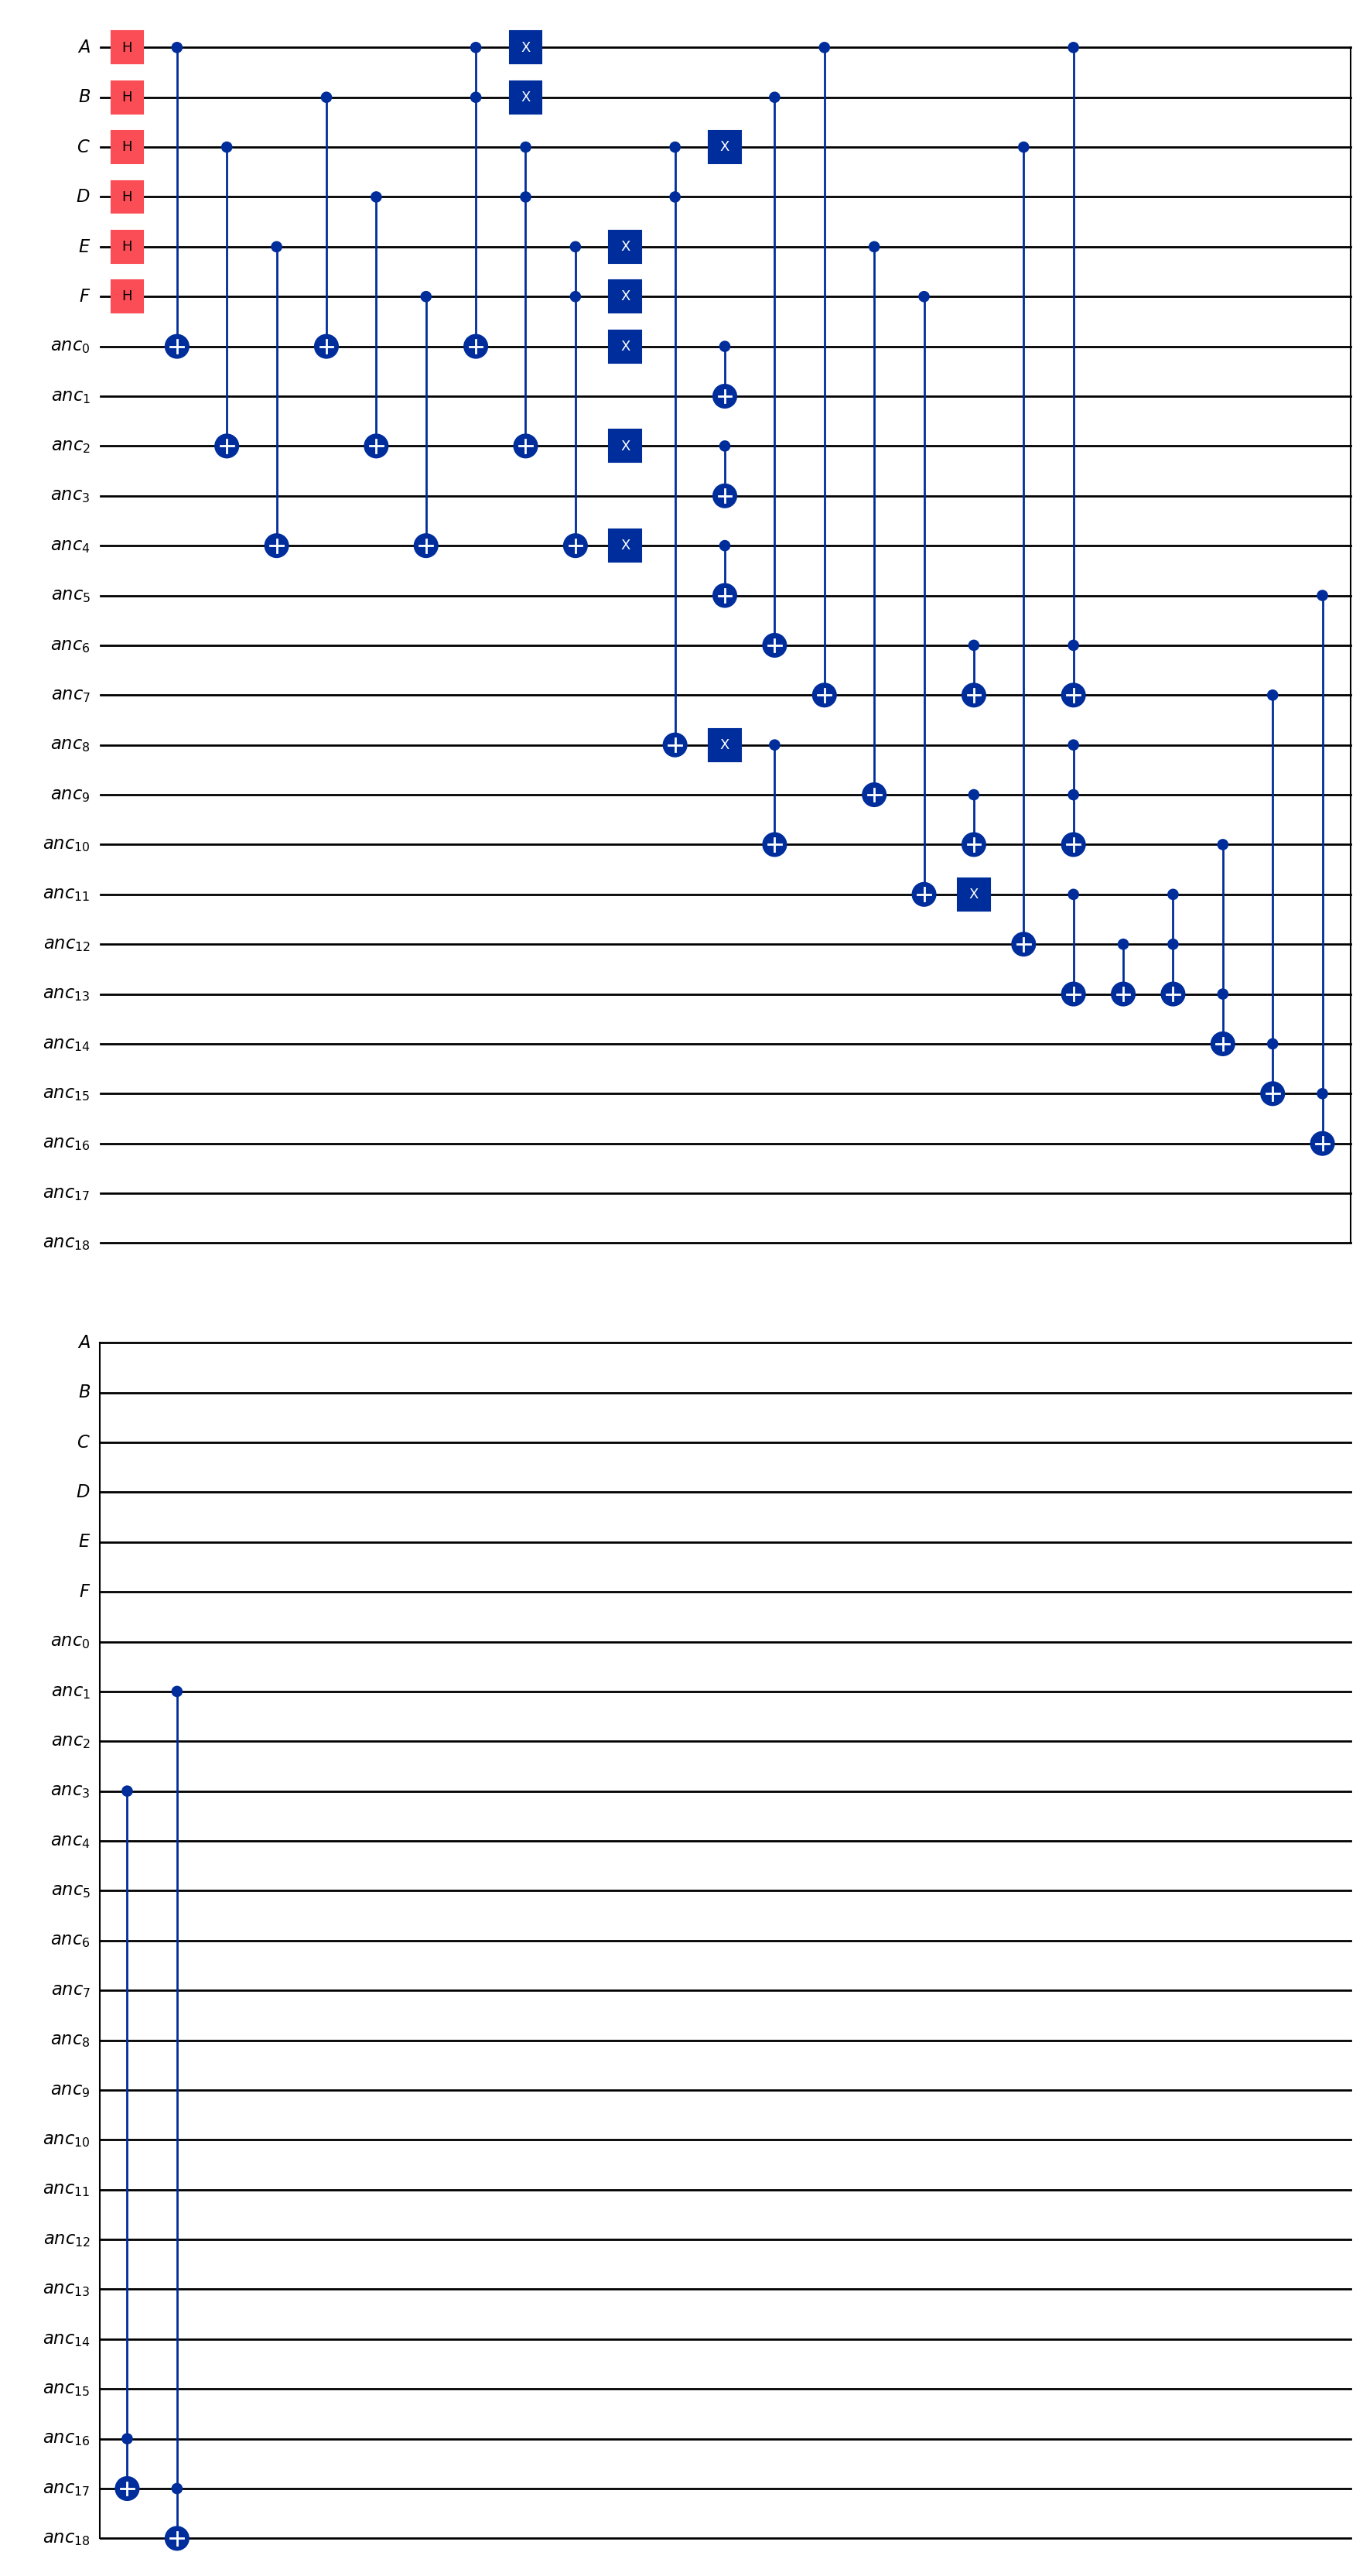

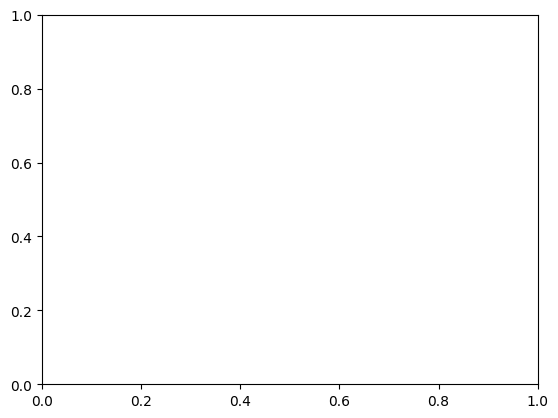

In [8]:
# Generate Quantum Circuit with Dynamic Qubit Allocation
qc, qubits_map = logical_to_quantum(formula)
print("Qubit Mapping:", qubits_map)

fig = figure()
ax = fig.add_subplot()

#ax.set_title(random_expression, fontsize=1, loc = 'left')

qc.draw('mpl')  #, ax = ax)  # Draw the circuit

## extract_variables

The function extract_variables($\textit{expr}$) is designed to recursively extract unique variables from a logical expression:
1.  The function takes an argument $\textit{expr}$, which represents a logical expression.
2.  It initializes an empty set called variables to store the unique variables found in the expression.
3.  The function then uses conditional statements to handle different types of expressions:
-   If $\textit{expr}$ is a list:
This indicates a compound expression (e.g., ["and", "A", "B"])
It iterates through the list elements starting from the second element (index 1) using $\textit{expr}$[1:].
This skips the first element, which is assumed to be the logical connective (e.g., "and", "or"). 
For each sub-expression, it recursively calls extract_variables and updates the variables set with the results.
-   If $\textit{expr}$ is a string:
This indicates a single variable (e.g., "A", "B") and adds the variable to the variables set.
4.  Finally, the function returns the variables set containing all unique variables found in the expression.
The use of a set is clever here because it automatically handles duplicates (a set only stores unique elements) and it allows for efficient updating and merging of variables from sub-expressions.
With this we parse nested logical expressions and identify all the unique variables used within them, which is essential for setting up the corresponding quantum circuit with the correct number of qubits.

## count_connectives

count_connectives($\textit{expr}$) recursively counts the number of logical connectives in a given logical expression:
1.  The function takes an argument $\textit{expr}$, which represents a logical expression.
2.  It initializes a variable count to 0. This will keep track of the number of connectives found.
3.   The function then checks if $\textit{expr}$ is a list using isinstance($\textit{expr}$, list), as in logical expressions represented as nested lists, each list typically represents a connective and its operands.
For example, ["and", "A", ["or", "B", "C"]] represents (A AND (B OR C)).
-  If expr is a list: It increments count by 1, as the list itself represents a connective, then iterates through the elements of the list starting from the second element ($\textit{expr}$[1:]). This is because the first element is typically the connective itself (e.g., "and", "or"), and we've already counted it.
For each sub-expression ($\textit{sub\_ expr}$) in the list, it recursively calls count_connectives($\textit{sub\_ expr}$) and adds the result to count.
This recursive call handles nested expressions, ensuring that connectives at all levels are counted.
- If expr is not a list (i.e., it's a single variable or constant), the function doesn't increment the count.
4.  Finally, the function returns the total count of connectives found.
This function is crucial for determining the number of ancilla qubits needed in the quantum circuit. Each logical connective in the expression will typically require an ancilla qubit to store intermediate results in the quantum implementation of the logical operation.

## resolve_expression

The resolve_expression function recursively resolves nested logical expressions and translates them into quantum gates in a quantum circuit.

1.  Parameters:
- expr: The logical expression to resolve
- circuit: The quantum circuit to add gates to
- qubits_map: A mapping of variable names to qubit indices
- ancilla_start: The starting index for ancilla qubits
- ancilla_counter: A counter for tracking ancilla qubit usage

2.  Base Case $\rightarrow{}$ if $\textit{expr}$ is a string, it's considered a variable, and the function returns its corresponding qubit index from qubits_map.

3.  Recursive Case $\rightarrow{}$ if $\textit{expr}$ is a list with more than one element, it's treated as a compound expression; such that the first element is the logical gate (e.g., "and", "or") and the remaining elements are the arguments for this gate

4.  Argument Resolution $\rightarrow{}$ the function recursively resolves each argument in the expression, collecting their corresponding qubit indices.

5.  Ancilla Allocation $\rightarrow{}$ an ancilla qubit is allocated for the current operation, with its index calculated using ancilla_start and ancilla_counter.

6.  Gate Application $\rightarrow{}$ based on the logical gate type, the function applies corresponding quantum gates.

7.  If an unknown or improperly formatted gate is encountered, it raises a ValueError. After this check, the function returns the index of the qubit storing the result of the current sub-expression.

This function is crucial in translating logical expressions into quantum circuits, handling nested expressions, and managing ancilla qubits for intermediate results.

## logical_to_quantum 

logical_to_quantum takes a logical expression and converts it into a quantum circuit with dynamic qubit allocation.

1.  It uses helper functions to extract unique variables and count the number of logical connectives in the expression via the previously defined functions extract_variables and count_connectives.

2.  It dynamically assigns qubits to the variables and ancillas in the order they are encountered. This ensures that each variable and ancilla is uniquely mapped to a qubit, preventing confusion in the quantum circuit.

3.  It creates a Quantum Register with Named Qubits for each variable, an ancilla for each logical conective and a final classical register for the output, and adds them to the quantum circuit.

4.  It applies Hadamard gates to the basis qubits (i.e., variables) to create superposition.

5.  It resolves the logical expression using the helper function resolve_expression, which translates the expression into quantum gates in the quantum circuit.

6.  Finally, it returns the quantum circuit and the mapping of variables to qubits.

This function effectively translates a logical expression into a quantum circuit, handling variable allocation, ancilla qubit management, and the application of appropriate quantum gates to represent the logical operations.

# Measurement to determine the params for AA.

In [9]:
sim = AerSimulator(method="matrix_product_state")
N_shots = 1000000  # number of measurements

In [10]:
prep_circ_out = qc.copy()
prep_circ_out.add_register(ClassicalRegister(1))
prep_circ_out.measure(len(qubits_map)-1, 0)

prep_circ_out_mes = qis.transpile(prep_circ_out, sim)

res = sim.run(prep_circ_out_mes, shots=N_shots, max_parallel_threads = 16).result()
coun = res.get_counts()

bas_probs_fin_out = {bitstring: count / N_shots for bitstring, count in coun.items()}


Estimated probabilities: {'0': 0.98449, '1': 0.01551}


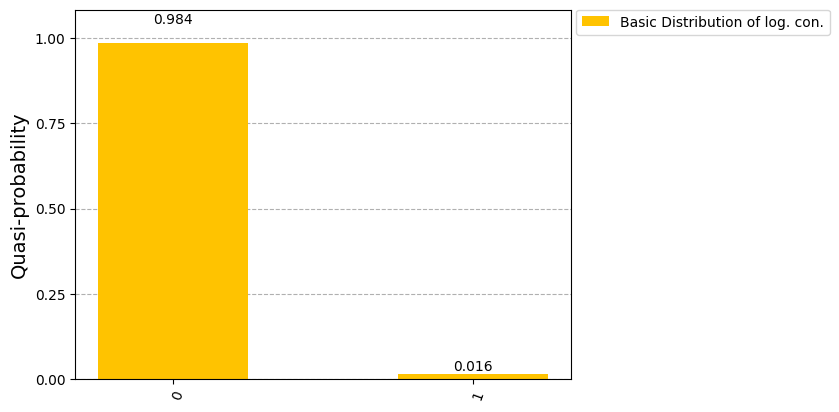

<Figure size 1200x600 with 0 Axes>

In [11]:
plt.figure(figsize=(12,6))
print("Estimated probabilities:", bas_probs_fin_out)
plot_histogram(bas_probs_fin_out, legend=["Basic Distribution of log. con."], color=["#FFC300"])

Estimated probabilities: {'000000': 0.015554, '110111': 0.015795, '011001': 0.015662, '101000': 0.015759, '111010': 0.015693, '001111': 0.015602, '100110': 0.015473, '000110': 0.015695, '101111': 0.015626, '110001': 0.015574, '010011': 0.015553, '100010': 0.015558, '111110': 0.01562, '001011': 0.015684, '010100': 0.015741, '010101': 0.015882, '010000': 0.015672, '111111': 0.015775, '001010': 0.015686, '100001': 0.01556, '111011': 0.015607, '100101': 0.015726, '001110': 0.01557, '010110': 0.015529, '111100': 0.015478, '001101': 0.015824, '100100': 0.015439, '110100': 0.015592, '101100': 0.015632, '000011': 0.015474, '001001': 0.015527, '110010': 0.015645, '101110': 0.015733, '000101': 0.015511, '000100': 0.015683, '110011': 0.01557, '101101': 0.015429, '111000': 0.015548, '010010': 0.015739, '011011': 0.015642, '011110': 0.01554, '101001': 0.015581, '010001': 0.015573, '100011': 0.015625, '111101': 0.015664, '001100': 0.015601, '100000': 0.015837, '000111': 0.015358, '110000': 0.01559, 

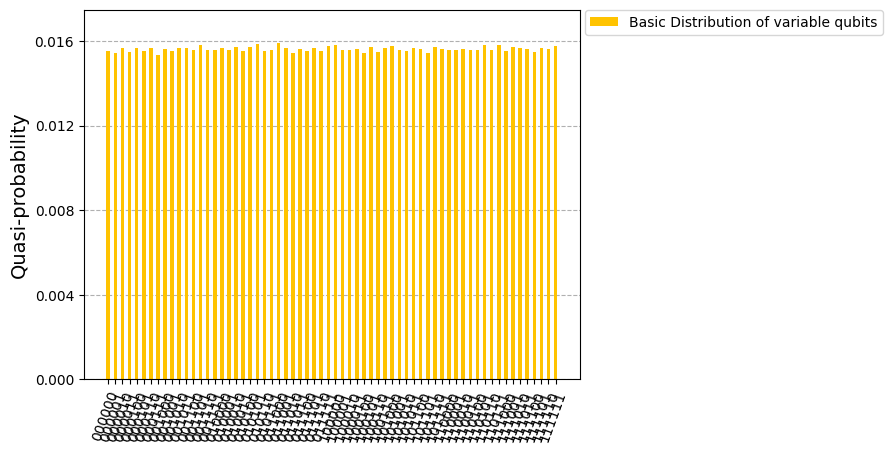

In [12]:
prep_circ_out_4 = qc.copy()
prep_circ_out_4.add_register(ClassicalRegister(6))
prep_circ_out_4.measure(list(i for i in range(6)), list(i for i in range(6)))

prep_circ_out_4_mes = qis.transpile(prep_circ_out_4, sim)

res_all = sim.run(prep_circ_out_4_mes, shots=1000000, max_parallel_threads = 16).result()
coun_all = res_all.get_counts()

bas_probs_var_out = {bitstring: count / N_shots for bitstring, count in coun_all.items()}
print("Estimated probabilities:", bas_probs_var_out)
plot_histogram(bas_probs_var_out, legend=["Basic Distribution of variable qubits"], color=["#FFC300"], bar_labels=0)

The measurements are being done by the built in qsikit.simulate method.

# AA. 

In [13]:
def oracle1(input_circ):
    len = input_circ.num_qubits
    b1 = QuantumCircuit(len)
    b1.z(len - 1)

    return b1

def oracle0(input_circ):
    len = input_circ.num_qubits
    b1 = QuantumCircuit(len)
    b1.x(len - 1)
    b1.z(len - 1)
    b1.x(len - 1)
    
    return b1

def diffusion(input_circ):
    len = input_circ.num_qubits
    b1 = QuantumCircuit(len)
    b2 = b1.compose(input_circ.inverse())

    for qubit in range(len ):
        b2.x(qubit)

    b2.h(len - 1)
    b2.mcx(list(range(0, len - 1)), len - 1)
    b2.h(len - 1)

    for qubit in range(len ):
        b2.x(qubit)

    diffusion = b2.compose(input_circ)

    return diffusion

def apply_sunscreen(circuit, oracle, amplifier, rounds):
    for _ in range(rounds):
        circuit = circuit.compose(oracle).compose(amplifier)

    return circuit



## Oracle

Defines an oracle for the procedure that marks the rigts states, either enting $\ket{0}$ os $\ket{1}$, depending on the fact that one is lower than the other and we want to show amplification.

## Apply the Oracle and Diffusion ops.

In [14]:
if bas_probs_fin_out['0'] < bas_probs_fin_out['1']:
    orac = oracle0(qc)
    rounds = int(np.floor(np.pi/4 * sqrt(1/(bas_probs_fin_out['0']))))
else:
    orac = oracle1(qc)
    rounds = int(np.floor(np.pi/4 * sqrt(1/(bas_probs_fin_out['1']))))

diff = diffusion(qc)

In [15]:
np.floor(np.pi/4 * sqrt(1/(bas_probs_fin_out['1'])))

6.0

In [16]:
orac.draw()

q_0: ─────
           
 q_1: ─────
           
 q_2: ─────
           
 q_3: ─────
           
 q_4: ─────
           
 q_5: ─────
           
 q_6: ─────
           
 q_7: ─────
           
 q_8: ─────
           
 q_9: ─────
           
q_10: ─────
           
q_11: ─────
           
q_12: ─────
           
q_13: ─────
           
q_14: ─────
           
q_15: ─────
           
q_16: ─────
           
q_17: ─────
           
q_18: ─────
           
q_19: ─────
           
q_20: ─────
           
q_21: ─────
           
q_22: ─────
           
q_23: ─────
      ┌───┐
q_24: ┤ Z ├
      └───┘

In [17]:
amplified_qc1 = apply_sunscreen(qc, orac, diff, 1) # Apply
amplified_qc2 = apply_sunscreen(qc, orac, diff, 2)
amplified_qc3 = apply_sunscreen(qc, orac, diff, 3)
amplified_qc4 = apply_sunscreen(qc, orac, diff, 4)
amplified_qc5 = apply_sunscreen(qc, orac, diff, 5)
amplified_qc6 = apply_sunscreen(qc, orac, diff, 6)
amplified_qc7 = apply_sunscreen(qc, orac, diff, 7)

In [18]:
print(dict(amplified_qc6.count_ops()))

{'x': 430, 'cx': 247, 'ccx': 156, 'h': 90, 'z': 6, 'mcx': 6}


In [19]:
amplified_qc1_c1 = amplified_qc1.copy()
amplified_qc1_c1.add_register(ClassicalRegister(1))

amplified_qc1_c1.measure(len(qubits_map)-1, 0)

amplified_qc1_c1_res = qis.transpile(amplified_qc1_c1, sim)

coun_1_1 = sim.run(amplified_qc1_c1_res, shots=1000000, max_parallel_threads = 16).result().get_counts()
amp_1_1 = {bitstring: count / N_shots for bitstring, count in coun_1_1.items()}


#-----------------------------------------------------------------------


amplified_qc1_c2 = amplified_qc2.copy()
amplified_qc1_c2.add_register(ClassicalRegister(1))

amplified_qc1_c2.measure(len(qubits_map)-1, 0)

amplified_qc1_c2_res = qis.transpile(amplified_qc1_c2, sim)

coun_1_2 = sim.run(amplified_qc1_c2_res, shots=1000000, max_parallel_threads = 16).result().get_counts()
amp_1_2 = {bitstring: count / N_shots for bitstring, count in coun_1_2.items()}

#-----------------------------------------------------------------------


amplified_qc1_c3 = amplified_qc3.copy()
amplified_qc1_c3.add_register(ClassicalRegister(1))

amplified_qc1_c3.measure(len(qubits_map)-1, 0)

amplified_qc1_c3_res = qis.transpile(amplified_qc1_c3, sim)

coun_1_3 = sim.run(amplified_qc1_c3_res, shots=1000000, max_parallel_threads = 16).result().get_counts()
amp_1_3 = {bitstring: count / N_shots for bitstring, count in coun_1_3.items()}

#-----------------------------------------------------------------------


amplified_qc1_c4 = amplified_qc4.copy()
amplified_qc1_c4.add_register(ClassicalRegister(1))

amplified_qc1_c4.measure(len(qubits_map)-1, 0)

amplified_qc1_c4_res = qis.transpile(amplified_qc1_c4, sim)

coun_1_4 = sim.run(amplified_qc1_c4_res, shots=1000000, max_parallel_threads = 16).result().get_counts()
amp_1_4 = {bitstring: count / N_shots for bitstring, count in coun_1_4.items()}

#-----------------------------------------------------------------------


amplified_qc1_c5 = amplified_qc5.copy()
amplified_qc1_c5.add_register(ClassicalRegister(1))

amplified_qc1_c5.measure(len(qubits_map)-1, 0)

amplified_qc1_c5_res = qis.transpile(amplified_qc1_c5, sim)

coun_1_5 = sim.run(amplified_qc1_c5_res, shots=1000000, max_parallel_threads = 16).result().get_counts()
amp_1_5 = {bitstring: count / N_shots for bitstring, count in coun_1_5.items()}

#-----------------------------------------------------------------------


amplified_qc1_c6 = amplified_qc6.copy()
amplified_qc1_c6.add_register(ClassicalRegister(1))

amplified_qc1_c6.measure(len(qubits_map)-1, 0)

amplified_qc1_c6_res = qis.transpile(amplified_qc1_c6, sim)

coun_1_6 = sim.run(amplified_qc1_c6_res, shots=1000000, max_parallel_threads = 16).result().get_counts()
amp_1_6 = {bitstring: count / N_shots for bitstring, count in coun_1_6.items()}

#-----------------------------------------------------------------------


amplified_qc1_c7 = amplified_qc7.copy()
amplified_qc1_c7.add_register(ClassicalRegister(1))

amplified_qc1_c7.measure(len(qubits_map)-1, 0)

amplified_qc1_c7_res = qis.transpile(amplified_qc1_c7, sim)

coun_1_7 = sim.run(amplified_qc1_c7_res, shots=1000000, max_parallel_threads = 16).result().get_counts()
amp_1_7 = {bitstring: count / N_shots for bitstring, count in coun_1_7.items()}

In [20]:
x = 6

amplfied_qcALL_c1 = amplified_qc1.copy()
amplfied_qcALL_c1.add_register(ClassicalRegister(x))

amplfied_qcALL_c1.measure(list(i for i in range(x)), list(i for i in range(x)))

amplfied_qcALL_c1_res = qis.transpile(amplfied_qcALL_c1, sim)

coun_all_1 = sim.run(amplfied_qcALL_c1_res, shots=1000000, max_parallel_threads = 16).result().get_counts()
amp_all_1 = {bitstring: count / N_shots for bitstring, count in coun_all_1.items()}

#-----------------------------------------------------------------------

amplfied_qcALL_c2 = amplified_qc2.copy()
amplfied_qcALL_c2.add_register(ClassicalRegister(x))

amplfied_qcALL_c2.measure(list(i for i in range(x)), list(i for i in range(x)))

amplfied_qcALL_c2_res = qis.transpile(amplfied_qcALL_c2, sim)

coun_all_2 = sim.run(amplfied_qcALL_c2_res, shots=1000000, max_parallel_threads = 16).result().get_counts()
amp_all_2 = {bitstring: count / N_shots for bitstring, count in coun_all_2.items()}

#-----------------------------------------------------------------------

amplfied_qcALL_c3 = amplified_qc3.copy()
amplfied_qcALL_c3.add_register(ClassicalRegister(x))

amplfied_qcALL_c3.measure(list(i for i in range(x)), list(i for i in range(x)))

amplfied_qcALL_c3_res = qis.transpile(amplfied_qcALL_c3, sim)

coun_all_3 = sim.run(amplfied_qcALL_c3_res, shots=1000000, max_parallel_threads = 16).result().get_counts()
amp_all_3 = {bitstring: count / N_shots for bitstring, count in coun_all_3.items()}

#-----------------------------------------------------------------------

amplfied_qcALL_c4 = amplified_qc4.copy()
amplfied_qcALL_c4.add_register(ClassicalRegister(x))

amplfied_qcALL_c4.measure(list(i for i in range(x)), list(i for i in range(x)))

amplfied_qcALL_c4_res = qis.transpile(amplfied_qcALL_c4, sim)

coun_all_4 = sim.run(amplfied_qcALL_c4_res, shots=1000000, max_parallel_threads = 16).result().get_counts()
amp_all_4 = {bitstring: count / N_shots for bitstring, count in coun_all_4.items()}

#-----------------------------------------------------------------------

amplfied_qcALL_c5 = amplified_qc5.copy()
amplfied_qcALL_c5.add_register(ClassicalRegister(x))

amplfied_qcALL_c5.measure(list(i for i in range(x)), list(i for i in range(x)))

amplfied_qcALL_c5_res = qis.transpile(amplfied_qcALL_c5, sim)

coun_all_5 = sim.run(amplfied_qcALL_c5_res, shots=1000000, max_parallel_threads = 16).result().get_counts()
amp_all_5 = {bitstring: count / N_shots for bitstring, count in coun_all_5.items()}

#-----------------------------------------------------------------------

amplfied_qcALL_c6 = amplified_qc6.copy()
amplfied_qcALL_c6.add_register(ClassicalRegister(x))

amplfied_qcALL_c6.measure(list(i for i in range(x)), list(i for i in range(x)))

amplfied_qcALL_c6_res = qis.transpile(amplfied_qcALL_c6, sim)

coun_all_6 = sim.run(amplfied_qcALL_c6_res, shots=1000000, max_parallel_threads = 16).result().get_counts()
amp_all_6 = {bitstring: count / N_shots for bitstring, count in coun_all_6.items()}

#-----------------------------------------------------------------------

amplfied_qcALL_c7 = amplified_qc7.copy()
amplfied_qcALL_c7.add_register(ClassicalRegister(x))

amplfied_qcALL_c7.measure(list(i for i in range(x)), list(i for i in range(x)))

amplfied_qcALL_c7_res = qis.transpile(amplfied_qcALL_c7, sim)

coun_all_7 = sim.run(amplfied_qcALL_c7_res, shots=1000000, max_parallel_threads = 16).result().get_counts()
amp_all_7 = {bitstring: count / N_shots for bitstring, count in coun_all_7.items()}


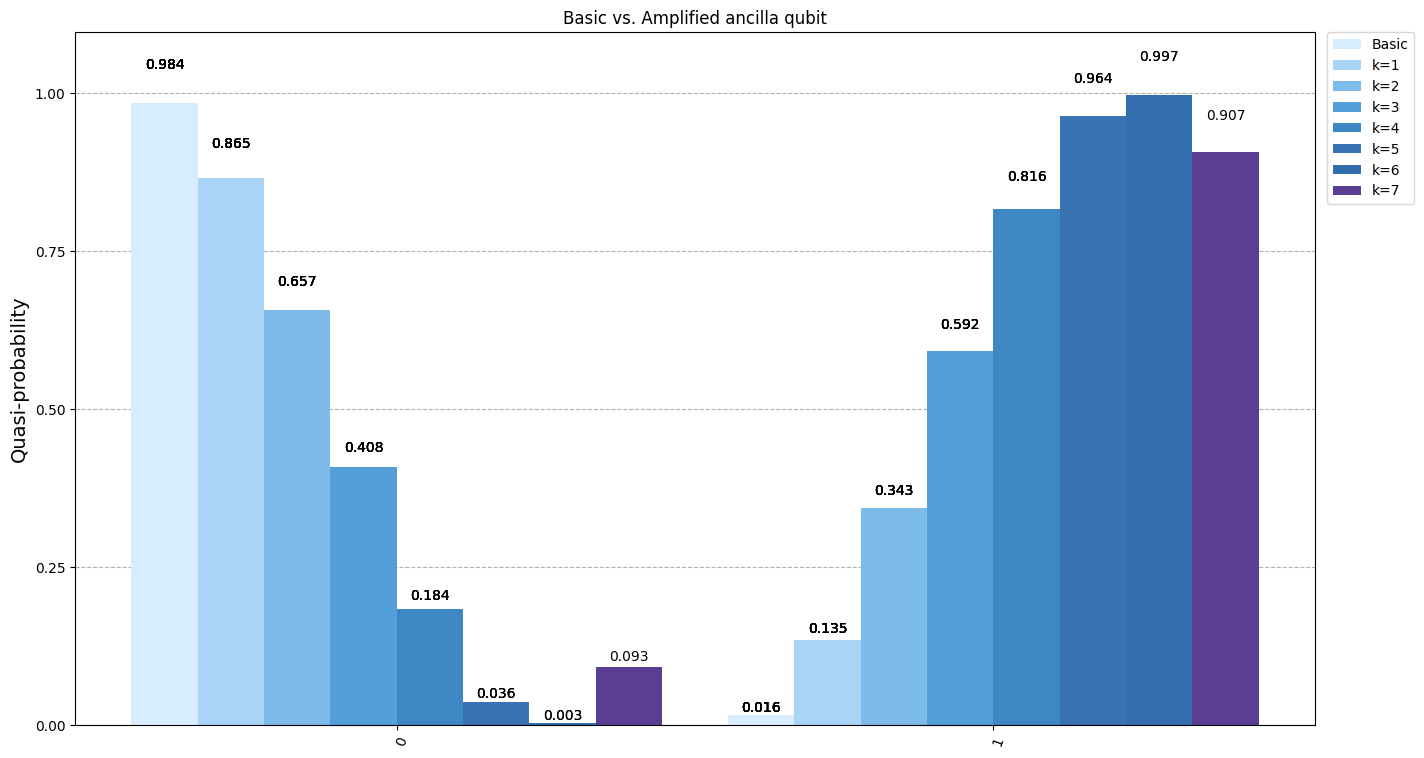

<Figure size 2100x900 with 0 Axes>

In [55]:
plt.figure(figsize=(21,9))
plot_histogram([bas_probs_fin_out, amp_1_1, amp_1_2, amp_1_3, amp_1_4, amp_1_5, amp_1_6, amp_1_7], 
            legend=["Basic", "k=1", "k=2", "k=3", "k=4", "k=5", "k=6", "k=7"], 
            color=['#D7ECFF', "#A9D4F5", "#7CBBEA", "#539FD9", "#3D87C5", "#3973B1", "#316DAF", '#5A3E91'],
            figsize=(16,9), 
            title="Basic vs. Amplified ancilla qubit")

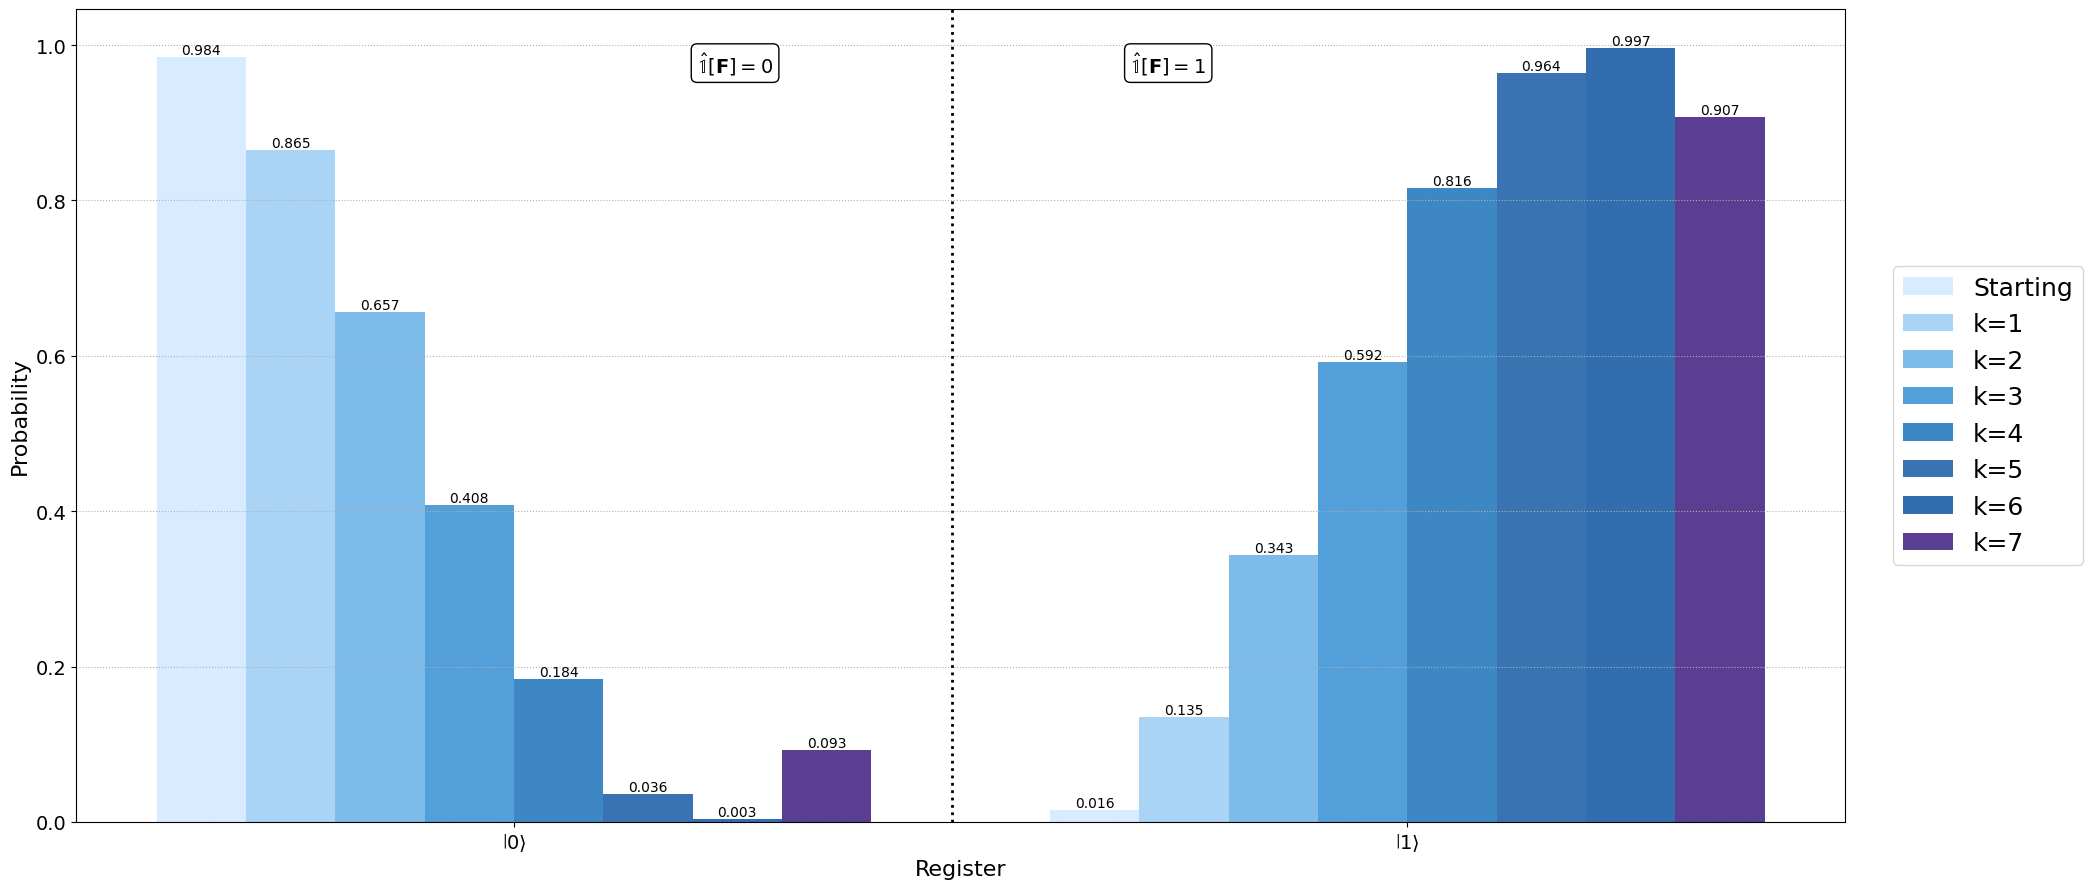

In [111]:
import matplotlib.pyplot as plt
import numpy as np

dicts = [bas_probs_fin_out, amp_1_1, amp_1_2, amp_1_3, amp_1_4, amp_1_5, amp_1_6, amp_1_7]
labels = ["Starting", "k=1", "k=2", "k=3", "k=4", "k=5", "k=6", "k=7"]
colors = ['#D7ECFF', "#A9D4F5", "#7CBBEA", "#539FD9", "#3D87C5", "#3973B1", "#316DAF", '#5A3E91']
all_states = sorted(set().union(*[d.keys() for d in dicts]))
x = np.arange(len(all_states))
width = 0.1
plt.figure(figsize=(21,9))
for i, (d, label, color) in enumerate(zip(dicts, labels, colors)):
    values = [d.get(state, 0) for state in all_states]
    bars = plt.bar(x + i*width, values, width=width, label=label, color=color)
    # Add text labels above bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.3f}', ha='center', va='bottom', fontsize=10)

plt.xticks(x + (len(dicts)-1)*width/2, [rf"$\left|{state}\right\rangle$" for state in all_states], fontsize=14)
plt.yticks(fontsize=14)
#plt.title("Basic vs. Amplified ancilla qubit", fontsize=14)
plt.xlabel("Register", fontsize=16)
plt.ylabel("Probability", fontsize=16)
plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), fontsize=18)

# Vertical dotted line in the middle
group_width = len(dicts) * width
midpoint = len(all_states) / 2  - group_width/5
plt.axvline(midpoint, color="black", linestyle=":", linewidth=2)

# Add textbox on the left side
plt.text(midpoint - 0.2, plt.ylim()[1]*0.95, r'$\hat{\mathbb{1}}[\mathbf{F}] = 0$', 
         fontsize=14, ha='right', va='top', bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='black'))

# Add textbox on the right side
plt.text(midpoint + 0.2, plt.ylim()[1]*0.95, r'$\hat{\mathbb{1}}[\mathbf{F}] = 1$', 
         fontsize=14, ha='left', va='top', bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='black'))

plt.grid(axis='y', linestyle=':', linewidth=0.8)

plt.tight_layout()
plt.show()


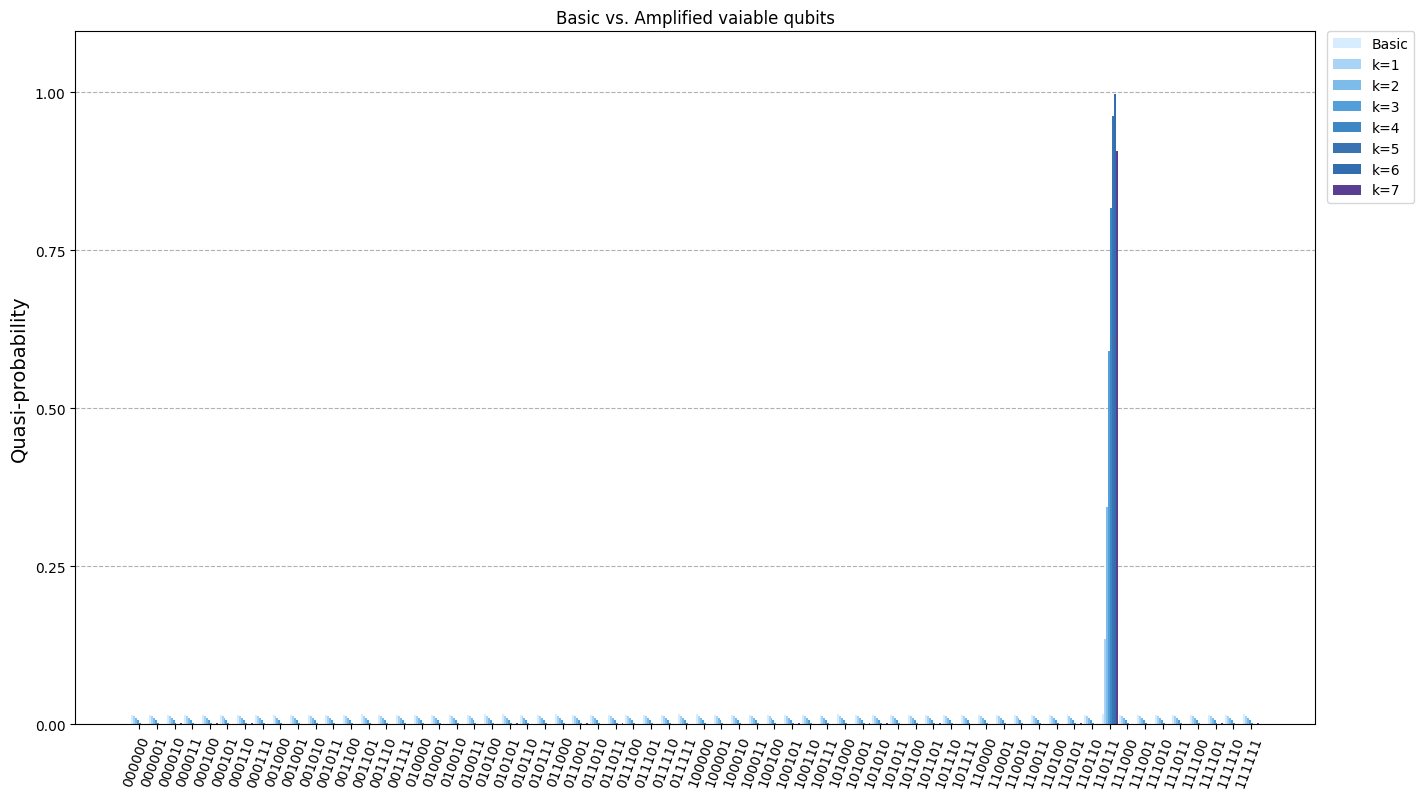

<Figure size 2100x900 with 0 Axes>

In [49]:
plt.figure(figsize=(21,9))
plot_histogram([bas_probs_var_out, amp_all_1, amp_all_2, amp_all_3, amp_all_4, amp_all_5, amp_all_6, amp_all_7],
            legend=["Basic", "k=1", "k=2", "k=3", "k=4", "k=5", "k=6", "k=7"], 
            color=['#D7ECFF', "#A9D4F5", "#7CBBEA", "#539FD9", "#3D87C5", "#3973B1", "#316DAF", '#5A3E91'],
            figsize=(16,9),
            title="Basic vs. Amplified vaiable qubits", bar_labels = 0)




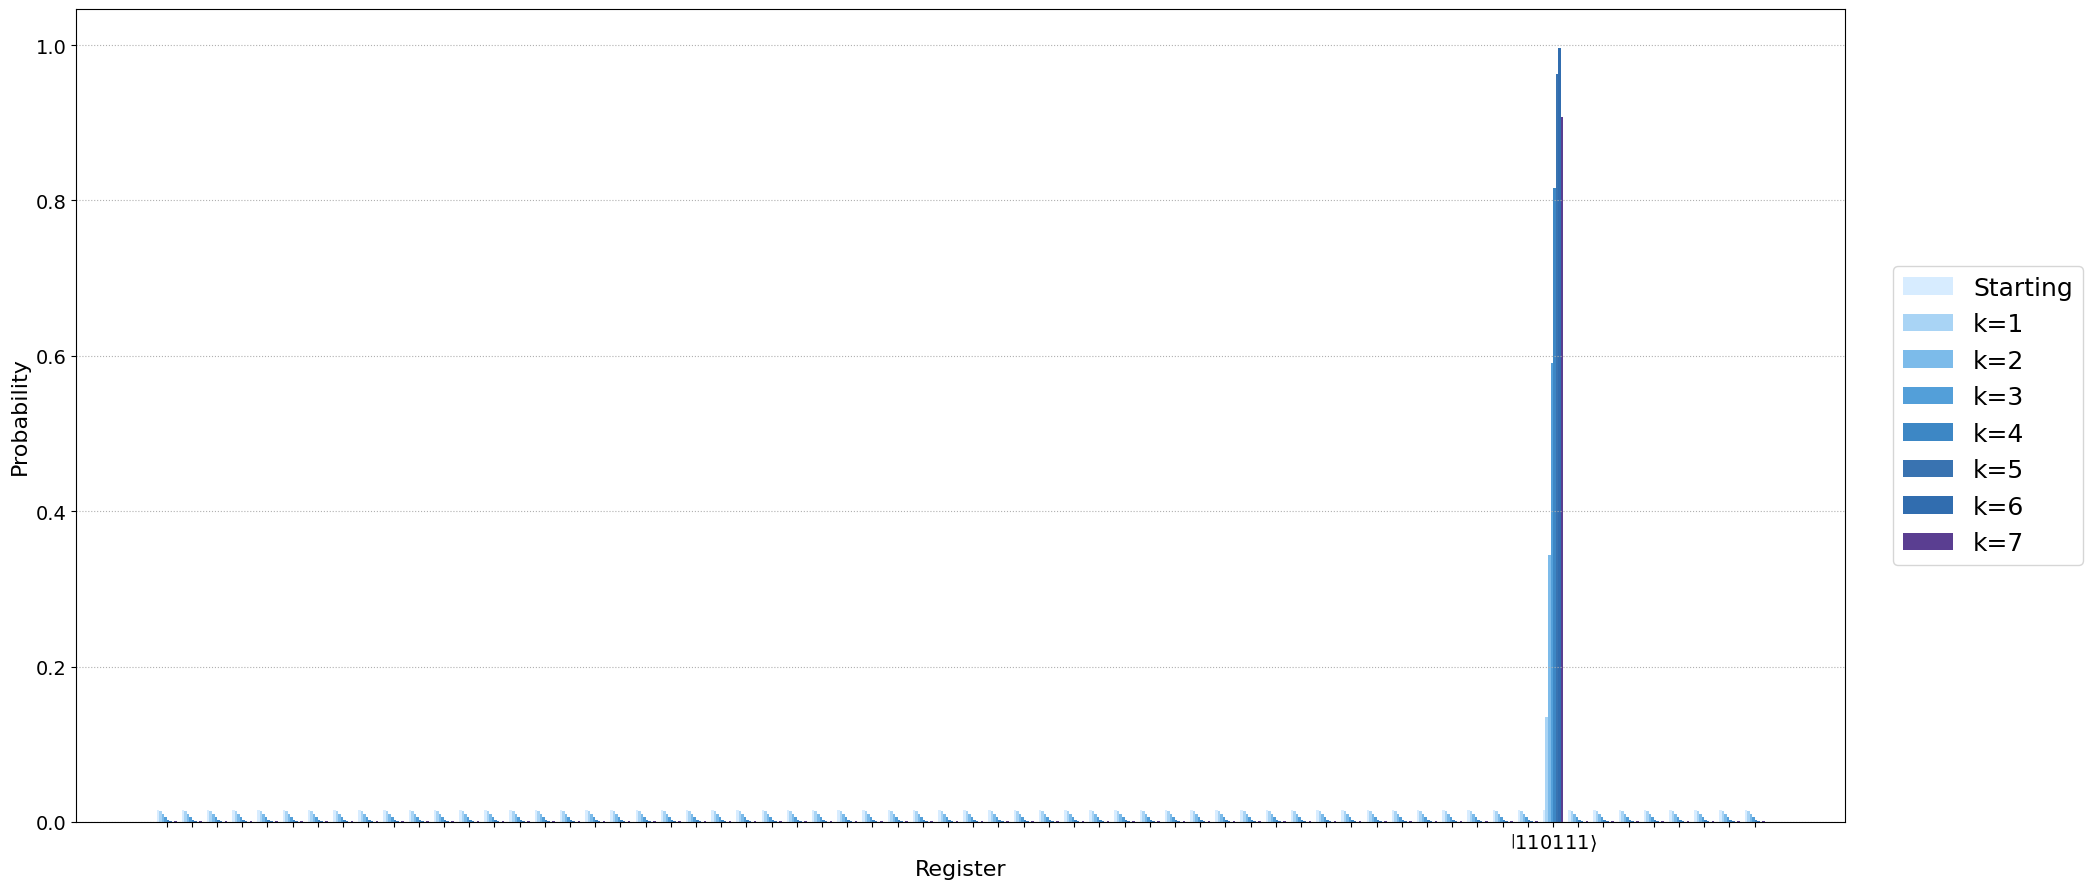

In [109]:
import matplotlib.pyplot as plt
import numpy as np

dicts = [bas_probs_var_out, amp_all_1, amp_all_2, amp_all_3, amp_all_4, amp_all_5, amp_all_6, amp_all_7]
labels = ["Starting", "k=1", "k=2", "k=3", "k=4", "k=5", "k=6", "k=7"]
colors = ['#D7ECFF', "#A9D4F5", "#7CBBEA", "#539FD9", "#3D87C5", "#3973B1", "#316DAF", '#5A3E91']
all_states = sorted(set().union(*[d.keys() for d in dicts]))
x = np.arange(len(all_states))
width = 0.1
plt.figure(figsize=(21,9))
for i, (d, label, color) in enumerate(zip(dicts, labels, colors)):
    values = [d.get(state, 0) for state in all_states]
    bars = plt.bar(x + i*width, values, width=width, label=label, color=color)

plt.xticks(x + (len(dicts)-1)*width/2, [rf"$\left|{state}\right\rangle$" for state in all_states], fontsize=14)
plt.yticks(fontsize=14)
#plt.title("Basic vs. Amplified ancilla qubit", fontsize=14)
plt.xlabel("Register", fontsize=16)
plt.ylabel("Probability", fontsize=16)
plt.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), fontsize=18)

keep_index = 55  # change this to the index of the state you want to keep the label for

labels = ["" for _ in all_states]
labels[keep_index] = rf"$\left|{all_states[keep_index]}\right\rangle$"

plt.xticks(x + (len(dicts)-1)*width/2, labels, fontsize=14)

plt.grid(axis='y', linestyle=':', linewidth=0.8)

plt.tight_layout()
plt.show()


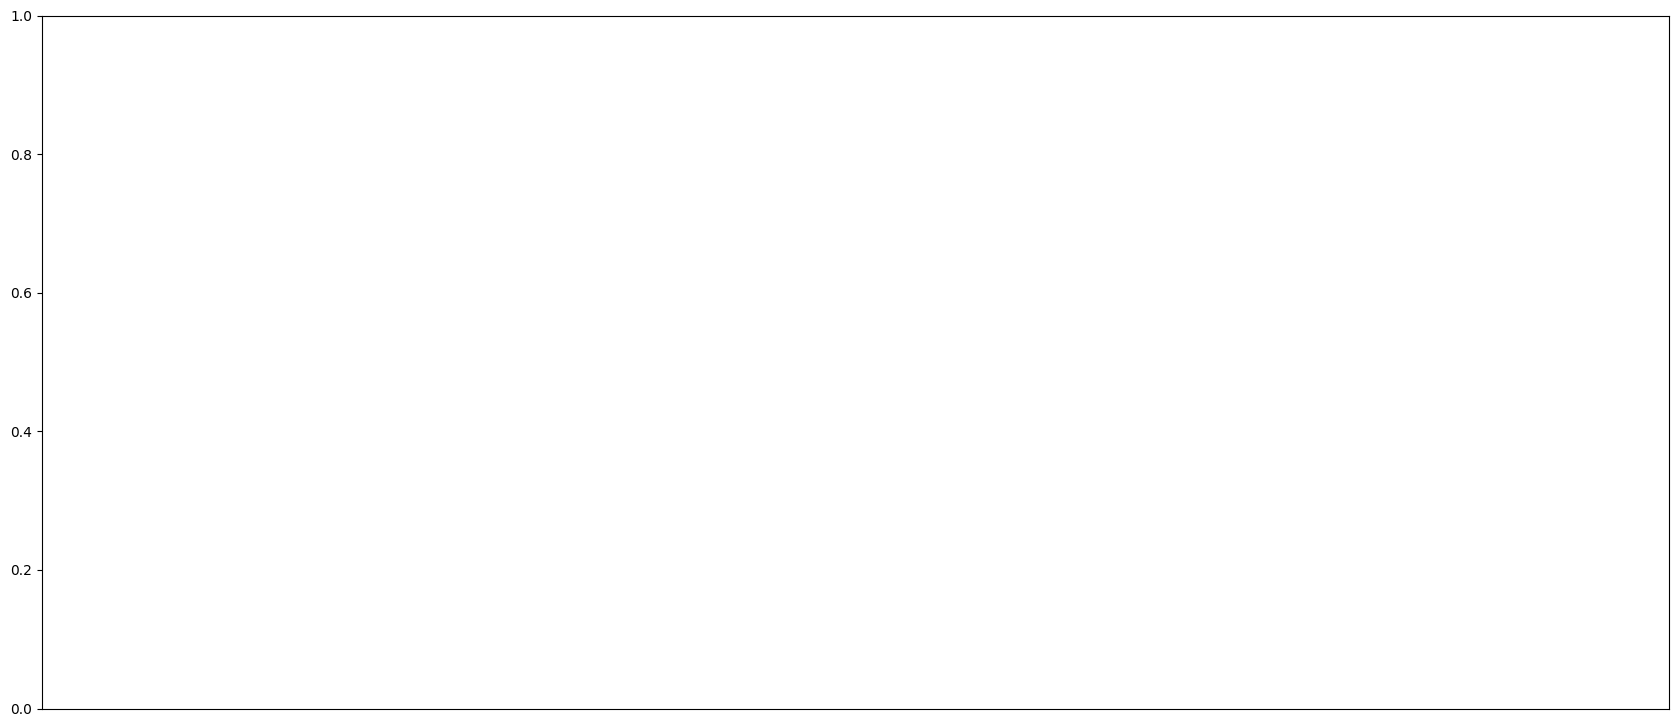

In [42]:
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt


plt.figure(figsize=(21,9))
plot_histogram(
    [bas_probs_var_out, amp_all_1, amp_all_2, amp_all_3, amp_all_4, amp_all_5, amp_all_6, amp_all_7],
    legend=["Basic", "k=1", "k=2", "k=3", "k=4", "k=5", "k=6", "k=7"], 
    color=['#D7ECFF', "#A9D4F5", "#7CBBEA", "#539FD9", "#3D87C5", "#3973B1", "#316DAF", '#5A3E91'],
    figsize=(16,9),
    title="Basic vs. Amplified final qubit with state 0",
    bar_labels=0
)

ax = plt.gca()
ax.set_xticks([])         # Remove all x-ticks and labels
ax.set_xticklabels([])    # Remove all x-tick labels

plt.show()

NameError: name 'your_probability_dict' is not defined

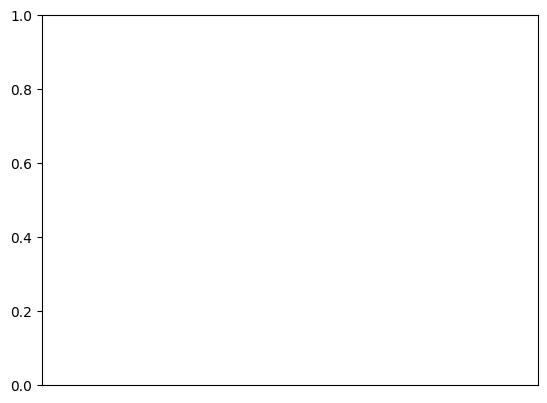

In [43]:
ax = plt.gca()
ax.set_xticks([])
ax.set_xticklabels([])

# Add manual annotation at the position you care about
# You must determine the bar position for '110111' (e.g., based on output probabilities dictionary's order)
bar_labels = list(your_probability_dict.keys())
target_label = '110111'
if target_label in bar_labels:
    idx = bar_labels.index(target_label)
    # Manually add text; adjust y-value and alignment as needed
    ax.annotate(target_label, xy=(idx, 0), xytext=(0, -20), 
                textcoords='offset points', ha='center', va='top', color='black')

plt.show()

In [25]:
import math
theta_k = []
p0 = 0.032
for i in (0.016, 0.134, 0.344, 0.592, 0.817, 0.963, 0.997, 0.908):
    theta_k.append(math.log(((1-p0)*i)/((1-i)*p0)))

theta_k

[-0.7095409903356218,
 1.5434510758653266,
 2.7639770529061596,
 3.7817356449566946,
 4.905649126495432,
 6.668631683630751,
 9.215634665770578,
 5.698951986029104]

# transpiling the circs.

In [37]:
from qiskit import QuantumCircuit, transpile
from qiskit_ionq import IonQProvider
from qiskit_ibm_runtime import QiskitRuntimeService

#api_key="hfXrOvg4UuaBAn2IXwyoPn25H7aO8Kmi" for TRAPPEDION
#api_key="DHjgH78VZkP9LzSImz4GR3bcEm_YFdqkoihFouBSHKKR" for SUPERCONDUCTING

#QiskitRuntimeService.save_account(channel="ibm_quantum", token="DHjgH78VZkP9LzSImz4GR3bcEm_YFdqkoihFouBSHKKR", overwrite=True)
#service = QiskitRuntimeService(channel="ibm_quantum", token="DHjgH78VZkP9LzSImz4GR3bcEm_YFdqkoihFouBSHKKR")


# Initialize the provider (requires IonQ API key)
provider = IonQProvider()

# Choose the trapped ion backend
backend1 = provider.get_backend("ionq_qpu", gateset="native")  # or "ionq_simulator" for simulation

# Transpile
transpiled_circuit_trapped = transpile(qc, backend=backend1)
gate_counts_trapped = transpiled_circuit_trapped.count_ops()
gate_counts_trapped

OrderedDict([('gpi2', 612), ('gpi', 124), ('ms', 91)])

In [28]:
service = QiskitRuntimeService()
backend2 = service.backend("ibm_brisbane")
transpiled_circuit_superc = transpile(qc, backend=backend2)
gate_counts_superc = transpiled_circuit_superc.count_ops()
gate_counts_superc

CloudResourceNameResolutionError: 'Failed to resolve CRN value for the provided service name None.'

In [27]:
import os
os.environ["QISKIT_IBM_TOKEN"] = "DHjgH78VZkP9LzSImz4GR3bcEm_YFdqkoihFouBSHKKR"

In [19]:
from qiskit_ibm_runtime import QiskitRuntimeService
QiskitRuntimeService.save_account(channel="ibm_quantum", token="DHjgH78VZkP9LzSImz4GR3bcEm_YFdqkoihFouBSHKKR", overwrite=True)

In [20]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService()
print(service.backends(simulator=False, operational=True, min_num_qubits=5))

[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_sherbrooke')>, <IBMBackend('ibm_torino')>]


In [ ]:
43800 microsec vs 88250 nanosec

In [ ]:
amplfied_circ_out4 = amplified_qc4.copy()
amplfied_circ_out4.add_register(ClassicalRegister(1))

amplfied_circ_out4.measure(len(qubits_map)-1, 0)

amplfied_circ_out4_4 = amplified_qc4.copy()
amplfied_circ_out4_4.add_register(ClassicalRegister(8))

amplfied_circ_out4_4.measure(list(i for i in range(8)), list(i for i in range(8)))

In [ ]:
sim = AerSimulator(method="matrix_product_state")
N_shots = 100000  # number of measurements

t_circ = qis.transpile(amplfied_circ_out4, sim)

result = sim.run(t_circ, shots=N_shots, max_parallel_threads = 12).result()
counts = result.get_counts()

amp_probs_out = {bitstring: count / N_shots for bitstring, count in counts.items()}
print("Estimated probabilities:", amp_probs_out)

In [ ]:
t_circ2 = qis.transpile(amplfied_circ_out4_4, sim)

result2 = sim.run(t_circ2, shots=N_shots, max_parallel_threads = 12).result()
counts2 = result2.get_counts()

amp_probs_in = {bitstring: count / N_shots for bitstring, count in counts2.items()}
print("Estimated probabilities:", amp_probs_in)

In [ ]:
plot_histogram([bas_probs_fin_out, amp_probs_out], legend=["Basic", "Amplified"], color=['#FFC300', '#C70039'],
                title="Basic vs. Amplified final qubit with state 0", bar_labels=0)

In [ ]:
plot_histogram([bas_probs_var_out, amp_probs_in], legend=["Basic", "Amplified"], color=['#FFC300', '#C70039'],
                title="Basic vs. Amplified final qubit with state 0", bar_labels=0)

## give the theta of the exp fam

In [ ]:
alpha = 

p = np.sin(alpha)^2

(4 - 4*p)*x = 60*p


In [ ]:
int(np.floor(np.pi/4 * sqrt(1/(prep_out['0']))))

In [ ]:
results_amplfied_circ_out4 = Sampler().run(amplfied_circ_out4).result()
amp_out4 = results_amplfied_circ_out4.quasi_dists[0].binary_probabilities()

In [ ]:
results_amplfied_circ_out4_4 = Sampler().run(amplfied_circ_out4_4).result()
amp_out4_4 = results_amplfied_circ_out4_4.quasi_dists[0].binary_probabilities()

In [ ]:
import random

LOGICAL_CONNECTIVES = ["and", "or", "not", "xor", "implication", "bijection"]

def generate_expression_with_limits(variables, total_qubits, max_depth=3, seed=None):
    """
    Generate a logical expression with limited depth and total qubit budget.
    
    Args:
        variables (list): List of variable names (e.g., ["A", "B", "C"]).
        total_qubits (int): Max number of qubits = variables + connectives (ancillas).
        max_depth (int): Maximum depth of the expression tree.
        seed (int or None): Seed for reproducibility.

    Returns:
        expression: Nested logical expression.
    """
    if seed is not None:
        random.seed(seed)

    connectives_used = [0]
    max_connectives = total_qubits 
    used_vars = set()

    def helper(depth):
        # Base case: max depth reached or no more ancilla budget
        if depth == 0 or connectives_used[0] >= max_connectives or (random.random() < 0.3 and len(used_vars) < len(variables)):
            var = random.choice(variables)
            used_vars.add(var)
            return var

        op = random.choice(LOGICAL_CONNECTIVES)

        if op == "not":
            if connectives_used[0] >= max_connectives:
                return random.choice(variables)
            connectives_used[0] += 1
            return ["not", helper(depth - 1)]

        # Binary ops
        if connectives_used[0] >= max_connectives:
            return random.choice(variables)
        
        connectives_used[0] += 1
        left = helper(depth - 1)
        right = helper(depth - 1)

        while right == left:
            right = helper(depth - 1)

        return [op, left, right]

    expression = helper(max_depth)
    return expression

variables = ["A", "B", "C", "D", "E", "F", "G", "H"]
total_qubits = 25  # vars + ancillas
max_depth = 5
seed = 123221

expr = generate_expression_with_limits(variables, total_qubits, max_depth, seed)
print(expr)


In [ ]:
variables = ["A", "B", "C", "D", "E", "F", "G", "H"]
total_qubits = 25  # vars + ancillas
max_depth = 5
seed = 123221

expr = generate_expression_with_limits(variables, total_qubits, max_depth, seed)
print(expr)
